[The Concrete Distribution: A Continuous Relaxation of Discrete Random Variables
](https://arxiv.org/abs/1611.00712)

Main problem:
$$
\Large\nabla_{\theta}E_{X \sim p_{\phi}}[f_{\theta}(X)]
$$

X is a discrete random variable.

We need to compute gradients with respect to $\theta$ and $\phi$.
- $\theta$
$$
\Large E_{X \sim p_{\phi}}[\nabla_{\theta}f_{\theta}(X)]
$$
<br>
Use Monte-Carlo sampling.
<br><br>
- $\phi$
$$
\Large\nabla_{\phi}E_{X \sim p_{\phi}}[f_{\theta}(X)] = \int f_{\theta}(x) \nabla_{\phi}p_{\phi}(x)
$$
<br>
It doesn't lead to Monte Carlo estimation.

### Score Function Estimators

SFE is also known as REINFORCE or likelihood ratio estimator.
Note that: <br><br>
$$
\Large \nabla_{\phi} log p_{\phi}(x) = \frac{1}{p_{\phi}(x)}\nabla_{\phi} p_{\phi}(x)
$$ 
<br><br>

So
$$
\Large \nabla_{\phi} p_{\phi}(x) = p_{\phi}(x) \nabla_{\phi} log p_{\phi}(x)
$$


<br><br>
- $\phi$
$$ 
\Large\nabla_{\phi}E_{X \sim p_{\phi}} [f_{\theta}(X)] = \int f_{\theta}(x) \nabla_{\phi}p_{\phi}(x) = \int f_{\theta}(x) p_{\phi}(x) \nabla_{\phi} log p_{\phi}(x) = E_{X \sim p_{\phi}} [f_{\theta}(X)\nabla_{\phi}log p_{\phi}(X)]
$$<br><br>
Now you can use Monte Carlo sampling
<br>

### Reparameterization Trick

In general to get a sample from $p_\phi (x)$, first sample Z from some fixed distribution q(z) and then transform this sample using some function $g_{\phi}(z)$.
<br>
Example:
<br>
$g_{\mu, \sigma}(Z) = \mu + \sigma * Z$, where Z is sampled from $N(0, 1)$.


$f_{\theta}(x) = f_{\theta}(g_{\phi}(z))$

$$
\Large E_{X \sim p_{\phi}(x)}[f_{\theta}(X)] = E_{Z \sim q(z)}[f_{\theta}(g_{\phi}(Z))]
$$

$$
\Large \nabla_{\phi}E_{Z \sim q(z)}[f_{\theta}(g_{\phi}(Z))] = E_{Z \sim q(z)}[f_{\theta}^{'}(g_{\phi}(Z))\nabla_{\phi}g_{\phi}(Z)]
$$

## The Concrete Distribution

### Discrete random variables and the Gumber-Max trick

Consider $(\alpha_{1}, ..., \alpha_{n})$, where $\alpha_{k}$ > 0. $D \sim Discrete(\alpha)$. We can assume that states with 0 probability are excluded.

Gumbel-Max-Trick:
- For each k, sample $U_{k} \sim Uniform(0, 1)$
- Find k that maximizes $(log \alpha_{k} - log(-U_{k})$ <br><br>
Then $P(D_{k}) = \frac{\alpha_{k}}{\sum_{i=1}^{n}\alpha_{i}}$

In [1]:
import numpy as np

In [2]:
alpha = (0.15, 0.55, 0.3)
epsilon = 1e-6

In [3]:
def take_sample(n_samples: int) -> np.ndarray:
    samples = []
    for _ in range(n_samples):
        u = np.random.uniform(0, 1, size=3)
        max_k = np.argmax(np.log(alpha) - np.log(-np.log(u)))
        samples.append(max_k)
    return np.array(samples)

In [4]:
samples1000 = take_sample(1000)

In [5]:
print(f'alpha1 probability: {(np.array(samples1000) == 0).mean()}')
print(f'alpha2 probability: {(np.array(samples1000) == 1).mean()}')
print(f'alpha3 probability: {(np.array(samples1000) == 2).mean()}')

alpha1 probability: 0.167
alpha2 probability: 0.548
alpha3 probability: 0.285


In [6]:
samples10000 = take_sample(10000)

In [7]:
print(f'alpha1 probability: {(np.array(samples10000) == 0).mean()}')
print(f'alpha2 probability: {(np.array(samples10000) == 1).mean()}')
print(f'alpha3 probability: {(np.array(samples10000) == 2).mean()}')

alpha1 probability: 0.1468
alpha2 probability: 0.5502
alpha3 probability: 0.303


In [8]:
samples100000 = take_sample(100000)

In [9]:
print(f'alpha1 probability: {(np.array(samples100000) == 0).mean()}')
print(f'alpha2 probability: {(np.array(samples100000) == 1).mean()}')
print(f'alpha3 probability: {(np.array(samples100000) == 2).mean()}')

alpha1 probability: 0.1481
alpha2 probability: 0.55218
alpha3 probability: 0.29972


### Concrete Random Variables

The derivative of the argmax is 0 everywhere except at the boundary of state changes, where it is
undefined. For this reason the Gumbel-Max trick is not a suitable reparameterization.

Simplex $\nabla^{n-1} = \{x \in R^{n}| x_{k} \in [0, 1], \sum_{k=1}^{n}x_{k} = 1\}$ <br>

To sample a Concrete random variable $X \in \nabla^{n-1}$ at temperature $\lambda \in (0, \infty)$, sample $G_{k} \sim Gumbel$ i.i.d. and set <br><br>
$\Large X_{k} = \frac{e^{(log (\alpha_{k}) + G_{k}) / \lambda}}{\sum_{i=1}^{n}e^{(log (\alpha_{i}) + G_{i}) / \lambda}}$

$\Large X \sim Concrete(\alpha, \lambda)$

The bigger $\lambda$ is, more relaxation is applied <br><br>
As a side note: $-log(-log U)$ has a Gumbel distribution (i.e. $Gumbel(0, 1)$)

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [11]:
gumbel = tfp.distributions.Gumbel(loc=0, scale=1)

In [12]:
us = np.log(-np.log(np.random.uniform(0, 1, size=100000)))

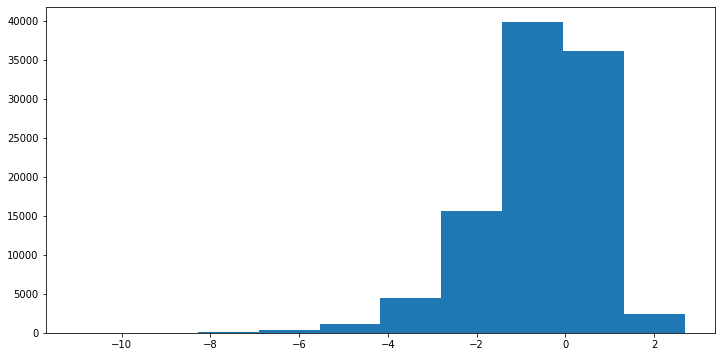

In [13]:
plt.subplots(figsize=(12, 6))
plt.hist(us);

In [14]:
x = np.linspace(-12, 2, 1000)

In [15]:
y = gumbel.prob(x)

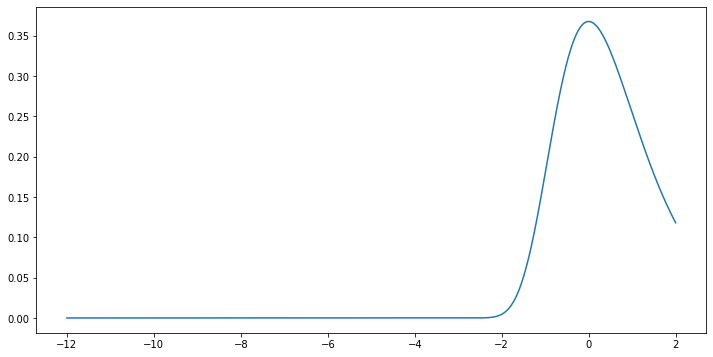

In [16]:
plt.subplots(figsize=(12, 6))
plt.plot(x, y);

In [17]:
gumbel.mean(), gumbel.variance()

(<tf.Tensor: shape=(), dtype=float32, numpy=0.5772157>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.6449342>)

In [18]:
np.mean(us), np.var(us)

(-0.5837117214179073, 1.6624762232378951)

In [19]:
def sample_gumble(n_samples: int):
    return np.log(-np.log(np.random.uniform(0, 1, size=n_samples)))

In [20]:
def sample_concrete(alphas, temperature: float):
    n = len(alphas)
    g = sample_gumble(n)
    
    return tf.nn.softmax((np.log(alphas) + g) / temperature).numpy()

In [21]:
alphas = (0.15, 0.55, 0.3)

In [22]:
sample_concrete(alphas, temperature=0.01)

array([1.22065115e-89, 1.00000000e+00, 2.02708582e-35])

In [23]:
sample_concrete(alphas, temperature=0.01)

array([7.37865420e-208, 1.00000000e+000, 4.88420683e-072])

In [24]:
sample_concrete(alphas, temperature=0.01)

array([7.92883130e-06, 9.99992071e-01, 2.75975907e-27])

In [25]:
sample_concrete(alphas, temperature=0.5)

array([4.56537861e-04, 3.44718922e-01, 6.54824541e-01])

In [26]:
sample_concrete(alphas, temperature=0.5)

array([0.01451632, 0.9732801 , 0.01220358])

In [27]:
n_samples = 10 ** 4
X = np.zeros((n_samples, 3))
for i in range(n_samples):
    X[i] = sample_concrete(alphas, temperature=0.5)

In [28]:
X.mean(axis=0)

array([0.14317753, 0.547239  , 0.30958348])

Check some properties of Concrete distribution (presented in the paper) <br><br>
(b) Rounding $P(X_{k} > X_{i}, i \ne k) = \alpha_{k} / \sum_{i=1}^{n}\alpha_{i}$

In [29]:
(np.argmax(X, axis=1) == 0).mean()

0.1118

In [30]:
(np.argmax(X, axis=1) == 1).mean()

0.5836

In [31]:
(np.argmax(X, axis=1) == 2).mean()

0.3046

In [32]:
n_samples = 10 ** 5
X = np.zeros((n_samples, 3))
for i in range(n_samples):
    X[i] = sample_concrete(alphas, temperature=0.5)

In [33]:
(np.argmax(X, axis=1) == 0).mean()

0.11077

In [34]:
(np.argmax(X, axis=1) == 1).mean()

0.58703

In [35]:
(np.argmax(X, axis=1) == 2).mean()

0.3022

In [36]:
X.mean(axis=0)

array([0.14101267, 0.54799432, 0.31099301])

### The Binary special case

$D \sim Discrete(\alpha)$ <br><br> $\alpha \sim (0, \infty)^{2}$ <br><br> $D_{1} + D_{2} = 1$

Under Gumbel-Max reparametrization, the event that $D_{1} = 1$ is that $\{G_{1} + log \alpha_{1} > G_{2} + log \alpha_{2}\}$
The difference of two Gumbels is a Logistic distribution $G_{1} - G_{2} \sim Logistic $ which can be sampled in the following way $G_{1} - G_{2} = log(U) - log (1 - U)$

So if, $\alpha = \frac{\alpha_{1}}{\alpha{2}}$, then we have <br><br>
$P(D_{1} = 1) = P(G_{1} + log \alpha_{1} > G_{2} + log \alpha_{2}) = P(log(U) - log (1 - U) + log(\alpha) > 0)$ <br>

$D_{1} = H(log(U) - log (1 - U) + log(\alpha))$, where H is the unit step function

Correspondingly, we can consider the Binary Concrete relaxation that results from this process. <br>We consider the sampling routine for a Binary Concrete random variable
$X \in (0, 1)$ first. To sample X, sample $L \sim Logistic$ and set

$\Large X = \frac{1}{1 + e^{-(log(\alpha) + L) / \lambda}}$

In [37]:
def sample_logistic(n_samples: int):
    u = np.random.uniform(0, 1, size=n_samples)
    return np.log(u) - np.log(1 - u)

In [38]:
def sample_binary(
    alpha1: float, 
    alpha2: float, 
    temperature: float,
    n_samples: int,
):
    alpha = alpha1 / alpha2
    logits = -(np.log(alpha) + sample_logistic(n_samples)) / temperature
    
    return 1 / (1 + np.exp(logits))

In [39]:
np.round(sample_binary(alpha1=0.4, alpha2=0.6, temperature=0.2, n_samples=10), 2)

array([0.41, 0.  , 0.92, 0.  , 0.97, 1.  , 1.  , 0.01, 0.57, 0.  ])

In [40]:
s = sample_binary(alpha1=0.4, alpha2=0.6, temperature=0.2, n_samples=10 ** 4)

In [41]:
np.mean(s)

0.4089985308573816

#### property from the paper
(b) (Rounding) $P(X > 0.5) = \alpha / (1 + \alpha)$

In [42]:
np.mean(s > 0.5)

0.4057